In [ ]:
!pip install pymupdf --quiet
!pip install openai --quiet
!pip install matplotlib --quiet
# instructor makes it easy to work with function calling
!pip install instructor --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.6/327.6 kB 9.8 MB/s eta 0:00:00


In [ ]:
import base64
import os
from enum import Enum
from io import BytesIO
from typing import Iterable
from typing import List
from typing import Literal, Optional

import fitz
# Instructor is powered by Pydantic, which is powered by type hints. Schema validation, prompting is controlled by type annotations
import instructor
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from PIL import Image
from openai import OpenAI
from pydantic import BaseModel, Field

Encoded image: chart.png


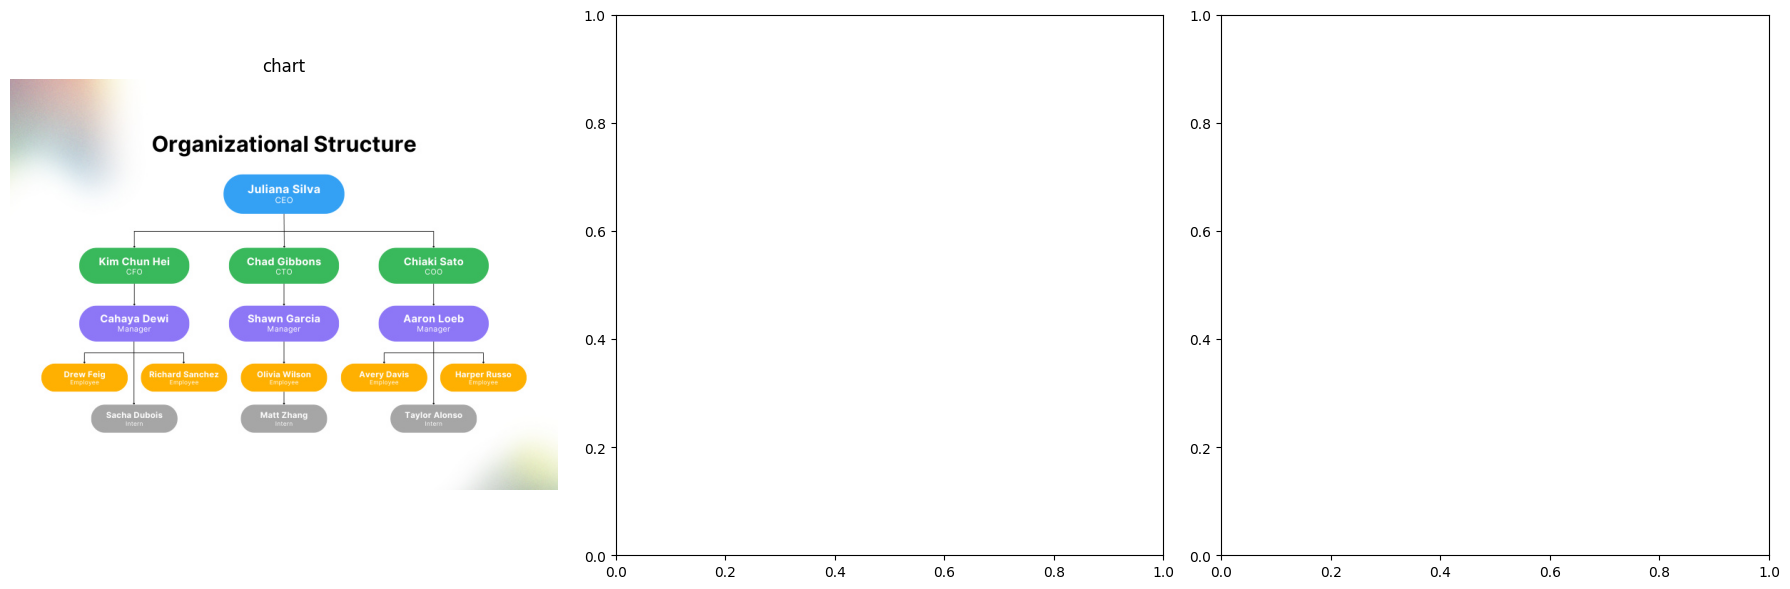

In [ ]:
# Function to encode the image as base64
def encode_image(image_path: str):
    # check if the image exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


# Sample images for testing
image_dir = "images"

# encode all images within the directory
image_files = os.listdir(image_dir)
image_data = {}
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    # encode the image with key as the image file name
    image_data[image_file.split('.')[0]] = encode_image(image_path)
    print(f"Encoded image: {image_file}")


def display_images(image_data: dict):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for i, (key, value) in enumerate(image_data.items()):
        img = Image.open(BytesIO(base64.b64decode(value)))
        ax = axs[i]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(key)
    plt.tight_layout()
    plt.show()


display_images(image_data)

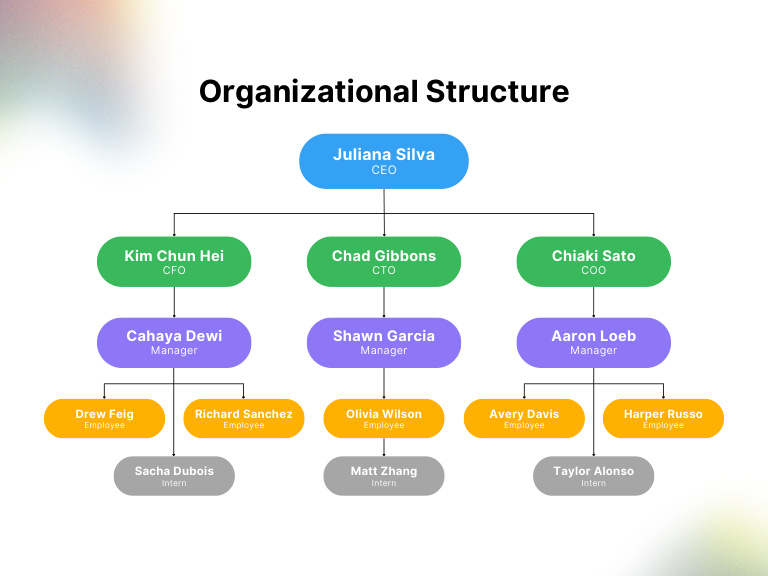

In [ ]:
# Function to convert a single page PDF page to a JPEG image
def convert_pdf_page_to_jpg(pdf_path: str, output_path: str, page_number=0):
    if not os.path.exists(pdf_path):
        raise FileNotFoundError(f"PDF file not found: {pdf_path}")
    doc = fitz.open(pdf_path)
    page = doc.load_page(page_number)  # 0 is the first page
    pix = page.get_pixmap()
    # Save the pixmap as a JPEG
    pix.save(output_path)


def display_img_local(image_path: str):
    img = Image.open(image_path)
    display(img)


pdf_path = '/content/sample_data/org-chart-sample.pdf'
output_path = 'org-chart-sample.jpg'

convert_pdf_page_to_jpg(pdf_path, output_path)
display_img_local(output_path)

In [ ]:
base64_img = encode_image(output_path)


os.environ["OPENAI_API_KEY"] = "OPEN_AI_KEY_HERE"

class RoleEnum(str, Enum):
    """Defines possible roles within an organization."""
    CEO = "CEO"
    CTO = "CTO"
    CFO = "CFO"
    COO = "COO"
    EMPLOYEE = "Employee"
    MANAGER = "Manager"
    INTERN = "Intern"
    OTHER = "Other"

class Employee(BaseModel):
    """Represents an employee, including their name, role, and optional manager information."""
    employee_name: str = Field(..., description="The name of the employee")
    role: RoleEnum = Field(..., description="The role of the employee")
    manager_name: Optional[str] = Field(None, description="The manager's name, if applicable")
    manager_role: Optional[RoleEnum] = Field(None, description="The manager's role, if applicable")


class EmployeeList(BaseModel):
    """A list of employees within the organizational structure."""
    employees: List[Employee] = Field(..., description="A list of employees")

def parse_orgchart(base64_img: str) -> EmployeeList:
    response = instructor.from_openai(OpenAI()).chat.completions.create(
        model='gpt-4-turbo',
        response_model=EmployeeList,
        messages=[
            {
                "role": "user",
                "content": 'Analyze the given organizational chart and very carefully extract the information.',
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_img}"
                        }
                    },
                ],
            }
        ],
    )
    return response

In [ ]:
# call the functions to analyze the organizational chart and parse the response
result = parse_orgchart(base64_img)

# tabulate the extracted data
df = pd.DataFrame([{
    'employee_name': employee.employee_name,
    'role': employee.role.value,
    'manager_name': employee.manager_name,
    'manager_role': employee.manager_role.value if employee.manager_role else None
} for employee in result.employees])

display(df)

,employee_name,role,manager_name,manager_role
0,Juliana Silva,CEO,None,None
1,Kim Chun Hei,CFO,Juliana Silva,CEO
2,Cahaya Dewi,Manager,Kim Chun Hei,CFO
3,Drew Feig,Employee,Cahaya Dewi,Manager
4,Richard Sanchez,Employee,Cahaya Dewi,Manager
5,Sacha Dubois,Intern,Cahaya Dewi,Manager
6,Chad Gibbons,CTO,Juliana Silva,CEO
7,Shawn Garcia,Manager,Chad Gibbons,CTO
8,Olivia Wilson,Employee,Shawn Garcia,Manager
9,Matt Zhang,Intern,Shawn Garcia,Manager
